# Reference

[강추. titanic kaggle input pipeline with tf.data](https://www.kaggle.com/alimaan/exploring-the-power-of-tensorflow-2-0-with-titanic)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
import re
if re.search('1.[0-9]+.[0-9]', tf.__version__):
    ! pip3 install tensorflow==2.4.0

print(tf.__version__)

2.4.0


Download train.csv and test.csv from [kaggle titanic](https://www.kaggle.com/c/titanic/data?select=test.csv)

In [3]:
import datetime
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import glob
print(glob.glob('./input/*'))

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline

['./input/test.csv', './input/train.csv']


In [6]:
%load_ext tensorboard

from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary
from google.protobuf import struct_pb2

In [5]:
train_data = pd.read_csv('./input/train.csv')
test_data = pd.read_csv('./input/test.csv')

In [9]:
train_data.info()
print('_'*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

dataframe describe shows only number-based columns.

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
for col in train_data.columns:
    if len(train_data[col].dropna()) <= (0.7 * len(train_data)):
        train_data.drop(columns=[col], inplace=True)
    else:
        train_data.dropna(axis=0, subset=[col], inplace=True)

for col in test_data.columns:
    if len(test_data[col].dropna()) <= (0.7 * len(test_data)):
        test_data.drop(columns=[col], inplace=True)
    else:
        test_data.dropna(axis=0, subset=[col], inplace=True)

In [14]:
train_data.info()
print('-'*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 0 to 415
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  331 non-null    int64  
 1  

<AxesSubplot:>

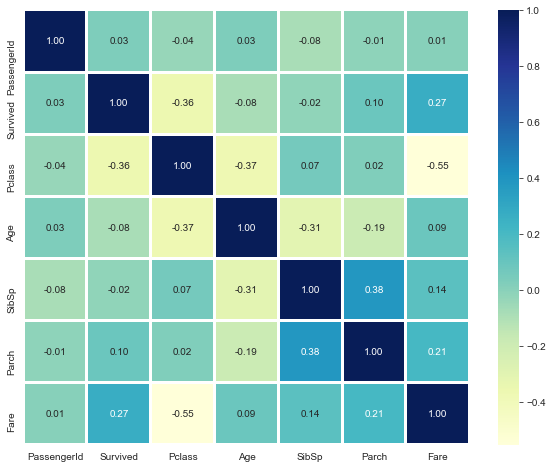

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(method='pearson'), annot=True, cmap='YlGnBu',fmt='.2f', linewidths=2)

In [18]:
feature_columns = []
for header in ['Age', 'Fare']:
    feature_columns.append(tf.feature_column.numeric_column(header))

age = tf.feature_column.numeric_column('Age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[5,10,20,30,40,50,60,70,80])
feature_columns.append(age_buckets)

In [19]:
categorical_cols = ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch']
for col in categorical_cols:
    train_data[col] = train_data[col].apply(str)
    test_data[col] = test_data[col].apply(str)
    cat_column_with_vocab = tf.feature_column.categorical_column_with_vocabulary_list(col, list(train_data[col].value_counts().index.values))
    one_hot = tf.feature_column.indicator_column(cat_column_with_vocab)
    feature_columns.append(one_hot)

In [20]:
ticket = tf.feature_column.categorical_column_with_hash_bucket('Ticket', hash_bucket_size=1000)
ticket_embedding = tf.feature_column.embedding_column(ticket, dimension=8)
feature_columns.append(ticket_embedding)

In [56]:
p_class = tf.feature_column.categorical_column_with_vocabulary_list('Pclass', list(train_data['Pclass'].value_counts().index.values))
parch = tf.feature_column.categorical_column_with_vocabulary_list('Parch', list(train_data['Parch'].value_counts().index.values))
pclass_parch_crossed = tf.feature_column.crossed_column([p_class, parch], hash_bucket_size=1000)
pclass_parch_crossed = tf.feature_column.indicator_column(pclass_parch_crossed)
feature_columns.append(pclass_parch_crossed)

In [72]:
list(train_data['Sex'].value_counts().index.values)
parch
pclass

NameError: name 'pclass' is not defined

In [70]:
tf.feature_column.crossed_column?

In [22]:
def df_to_dataset(dataframe, testing=False, batch_size=32):
    dataframe = dataframe.copy()
    if not testing:
        labels = dataframe.pop('Survived')
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        ds = ds.shuffle(buffer_size=len(dataframe))
    else:
        ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [23]:
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [24]:
batch_size = 32
train_ds = df_to_dataset(train_data, batch_size=batch_size)
val_ds = df_to_dataset(val_data, batch_size=batch_size)
test_ds = df_to_dataset(test_data, testing=True, batch_size=batch_size)

## Hyperparameter tuning

In [25]:
num_units_list = [128, 256]
dropout_rate_list = [0.2, 0.5]
optimizer_list = ['adam', 'sgd']

In [42]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(hparams['num_units'], activation='relu'),
        tf.keras.layers.Dropout(hparams['dropout_rate']),
        tf.keras.layers.Dense(hparams['num_units'], activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=hparams['optimizer'],
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(train_ds,
             validation_data=val_ds,
              epochs=50,
              use_multiprocessing=True,
              verbose=1)
    _, accuracy = model.evaluate(val_ds)
    return model, accuracy

In [47]:
def run(run_dir, hparams):
    writer = tf.summary.create_file_writer(run_dir)
    summary_start = hparams_summary.session_start_pb(hparams=hparams)
    
    with writer.as_default():
        model, accuracy = train_test_model(hparams)
        summary_end = hparams_summary.session_end_pb(api_pb2.STATUS_SUCCESS)
        
        tf.summary.scalar('accuracy', accuracy, step=1, description='The accuracy')
        return model, accuracy


In [48]:
model_dict = {}
session_num = 0
for num_units in num_units_list:
    for dropout_rate in dropout_rate_list:
        for optimizer in optimizer_list:
            hparams = {'num_units': num_units, 'dropout_rate': dropout_rate, 'optimizer':optimizer}
            print(f'--- Running training session {session_num + 1}')
            print(hparams)
            run_name = 'run-'+ str(session_num)
            model, accuracy = run('./logs/hparam_tuning/' + run_name,hparams)
            print(accuracy)
            model_dict[accuracy] = model
            session_num += 1

--- Running training session 1
{'num_units': 128, 'dropout_rate': 0.2, 'optimizer': 'adam'}
Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/18 [>.............................] - ETA: 15s - loss: 1.4603 - accuracy: 0.3750WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'PassengerId': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'Pclass': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'Name': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'Sex': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=string>, 'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'SibSp': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'Parch': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'Ticket': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'Fare': <tf.Tensor 'ExpandDims_

18/18 [==============================] - 0s 7ms/step - loss: 0.0691 - accuracy: 0.9792 - val_loss: 0.7572 - val_accuracy: 0.7762
Epoch 40/50
18/18 [==============================] - 0s 7ms/step - loss: 0.1081 - accuracy: 0.9583 - val_loss: 0.7962 - val_accuracy: 0.7622
Epoch 41/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0639 - accuracy: 0.9709 - val_loss: 0.7625 - val_accuracy: 0.7762
Epoch 42/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0736 - accuracy: 0.9702 - val_loss: 0.7740 - val_accuracy: 0.7692
Epoch 43/50
18/18 [==============================] - 0s 5ms/step - loss: 0.0574 - accuracy: 0.9831 - val_loss: 0.8131 - val_accuracy: 0.7692
Epoch 44/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0637 - accuracy: 0.9844 - val_loss: 0.8723 - val_accuracy: 0.7692
Epoch 45/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0563 - accuracy: 0.9850 - val_loss: 0.9083 - val_accuracy: 0.7692
Epoch 46/50
18/18 [======

Epoch 27/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6597 - accuracy: 0.6497 - val_loss: 0.5799 - val_accuracy: 0.6713
Epoch 28/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6064 - accuracy: 0.6991 - val_loss: 0.5723 - val_accuracy: 0.6853
Epoch 29/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5820 - accuracy: 0.7175 - val_loss: 0.5739 - val_accuracy: 0.6923
Epoch 30/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6164 - accuracy: 0.6894 - val_loss: 0.5817 - val_accuracy: 0.6713
Epoch 31/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6245 - accuracy: 0.6661 - val_loss: 0.5798 - val_accuracy: 0.6853
Epoch 32/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6123 - accuracy: 0.6829 - val_loss: 0.5699 - val_accuracy: 0.6713
Epoch 33/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6116 - accuracy: 0.7057 - val_loss: 0.5779 - val_accuracy: 0.7063
Epoch 34/50
1

Epoch 15/50
18/18 [==============================] - 0s 6ms/step - loss: 0.4733 - accuracy: 0.7922 - val_loss: 0.4192 - val_accuracy: 0.8322
Epoch 16/50
18/18 [==============================] - 0s 6ms/step - loss: 0.4401 - accuracy: 0.8381 - val_loss: 0.4126 - val_accuracy: 0.8252
Epoch 17/50
18/18 [==============================] - 0s 6ms/step - loss: 0.4436 - accuracy: 0.8246 - val_loss: 0.4011 - val_accuracy: 0.8741
Epoch 18/50
18/18 [==============================] - 0s 6ms/step - loss: 0.3826 - accuracy: 0.8594 - val_loss: 0.4108 - val_accuracy: 0.8252
Epoch 19/50
18/18 [==============================] - 0s 6ms/step - loss: 0.4441 - accuracy: 0.8214 - val_loss: 0.3831 - val_accuracy: 0.8881
Epoch 20/50
18/18 [==============================] - 0s 6ms/step - loss: 0.3702 - accuracy: 0.8616 - val_loss: 0.3890 - val_accuracy: 0.8951
Epoch 21/50
18/18 [==============================] - 0s 6ms/step - loss: 0.3783 - accuracy: 0.8741 - val_loss: 0.4173 - val_accuracy: 0.8601
Epoch 22/50
1

Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6395 - accuracy: 0.6496 - val_loss: 0.6068 - val_accuracy: 0.6713
Epoch 4/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6541 - accuracy: 0.6701 - val_loss: 0.5888 - val_accuracy: 0.6783
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.6433 - val_loss: 0.5880 - val_accuracy: 0.6783
Epoch 6/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6636 - accuracy: 0.6871 - val_loss: 0.5980 - val_accuracy: 0.6503
Epoch 7/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6365 - accuracy: 0.6856 - val_loss: 0.5953 - val_accuracy: 0.6503
Epoch 8/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6109 - accuracy: 0.6798 - val_loss: 0.5898 - val_accuracy: 0.6783
Epoch 9/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6235 - accuracy: 0.6717 - val_loss: 0.5976 - val_accuracy: 0.6573
Epoch 10/50
18/18 [=

16/18 [=========================>....] - ETA: 0s - loss: 1.4291 - accuracy: 0.5725 WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'PassengerId': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'Pclass': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'Name': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'Sex': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=string>, 'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'SibSp': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'Parch': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'Ticket': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'Fare': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'Embarked': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
18/18 [==============================] - 1s 29ms/s

Consider rewriting this model with the Functional API.
16/18 [=========================>....] - ETA: 0s - loss: 1.4508 - accuracy: 0.5451 WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'PassengerId': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'Pclass': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'Name': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'Sex': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=string>, 'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'SibSp': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'Parch': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'Ticket': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'Fare': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'Embarked': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional 

18/18 [==============================] - 0s 6ms/step - loss: 0.6005 - accuracy: 0.6864 - val_loss: 0.5646 - val_accuracy: 0.6993
Epoch 47/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5988 - accuracy: 0.6925 - val_loss: 0.5581 - val_accuracy: 0.6853
Epoch 48/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6064 - accuracy: 0.6871 - val_loss: 0.5539 - val_accuracy: 0.6993
Epoch 49/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6013 - accuracy: 0.6913 - val_loss: 0.5564 - val_accuracy: 0.6853
Epoch 50/50
5/5 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.6853
0.6853147149085999
--- Running training session 7
{'num_units': 256, 'dropout_rate': 0.5, 'optimizer': 'adam'}
Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
16/18 [=========================>....] - ETA: 0s - loss: 0.9114 - accuracy: 0.5867 WARNING:tensorflow:Layers in a Seque

Epoch 34/50
18/18 [==============================] - 0s 7ms/step - loss: 0.1552 - accuracy: 0.9397 - val_loss: 0.6343 - val_accuracy: 0.7552
Epoch 35/50
18/18 [==============================] - 0s 6ms/step - loss: 0.1664 - accuracy: 0.9319 - val_loss: 0.6964 - val_accuracy: 0.7413
Epoch 36/50
18/18 [==============================] - 0s 8ms/step - loss: 0.1930 - accuracy: 0.9277 - val_loss: 0.6539 - val_accuracy: 0.7483
Epoch 37/50
18/18 [==============================] - 0s 6ms/step - loss: 0.1851 - accuracy: 0.9295 - val_loss: 0.7355 - val_accuracy: 0.7413
Epoch 38/50
18/18 [==============================] - 0s 6ms/step - loss: 0.1691 - accuracy: 0.9302 - val_loss: 0.6730 - val_accuracy: 0.7483
Epoch 39/50
18/18 [==============================] - 0s 6ms/step - loss: 0.1658 - accuracy: 0.9318 - val_loss: 0.7025 - val_accuracy: 0.7413
Epoch 40/50
18/18 [==============================] - 0s 6ms/step - loss: 0.1231 - accuracy: 0.9506 - val_loss: 0.7452 - val_accuracy: 0.7273
Epoch 41/50
1

Epoch 22/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6279 - accuracy: 0.6630 - val_loss: 0.5961 - val_accuracy: 0.6783
Epoch 23/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6493 - accuracy: 0.6752 - val_loss: 0.5823 - val_accuracy: 0.6713
Epoch 24/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5849 - accuracy: 0.7012 - val_loss: 0.5950 - val_accuracy: 0.6853
Epoch 25/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6517 - accuracy: 0.6476 - val_loss: 0.5719 - val_accuracy: 0.6783
Epoch 26/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6796 - accuracy: 0.6518 - val_loss: 0.5709 - val_accuracy: 0.6783
Epoch 27/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5977 - accuracy: 0.6933 - val_loss: 0.5747 - val_accuracy: 0.6783
Epoch 28/50
18/18 [==============================] - 0s 6ms/step - loss: 0.6320 - accuracy: 0.6836 - val_loss: 0.5750 - val_accuracy: 0.6643
Epoch 29/50
1

In [55]:
best_model = model_dict[max(list(model_dict.keys()))]
model_dict

{0.7132866978645325: <tensorflow.python.keras.engine.sequential.Sequential at 0x7fcc71dcac88>,
 0.6783216595649719: <tensorflow.python.keras.engine.sequential.Sequential at 0x7fcc78b85208>,
 0.7412587404251099: <tensorflow.python.keras.engine.sequential.Sequential at 0x7fcc73b70940>,
 0.7692307829856873: <tensorflow.python.keras.engine.sequential.Sequential at 0x7fcc7a230080>,
 0.6853147149085999: <tensorflow.python.keras.engine.sequential.Sequential at 0x7fcc7cb88c88>,
 0.748251736164093: <tensorflow.python.keras.engine.sequential.Sequential at 0x7fcc78ae66a0>}

In [50]:
predictions = best_model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

Consider rewriting this model with the Functional API.


In [52]:
predictions_dataframe = test_data[['PassengerId']]
predictions_dataframe["Survived"] = predictions

In [53]:
predictions_dataframe.to_csv("gender_submission.csv",index=False)

In [54]:
best_model.save('best_model.h5')